<a href="https://colab.research.google.com/github/joeygaule/ML-PredicativeAnalaytics/blob/main/Brain_Tumor_Classification_Project_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Classification Project Using CNN
Objective:
Develop a CNN model to classify brain tumors from MRI images into different categories (e.g., glioma, meningioma, pituitary tumor, or no tumor).

# Load the Data and Libraries

In [ ]:
import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

# Unzip the dataset
zip_path = '/content/drive/MyDrive/School/Machine Learning/Project_final/Brain MRI Images.zip'
extract_path = '/mnt/data/brain_mri_images'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify the contents of the extracted files
extracted_files = os.listdir(extract_path)
print(extracted_files)

['brain_tumor_dataset', 'yes', 'no']


#  Exploratory Data Analysis (EDA)


- Analyze the distribution of tumor vs. non-tumor images.
- Visualize sample images and their corresponding labels.
- Check image dimensions and pixel intensity distributions.
- Identify any missing or corrupted data.

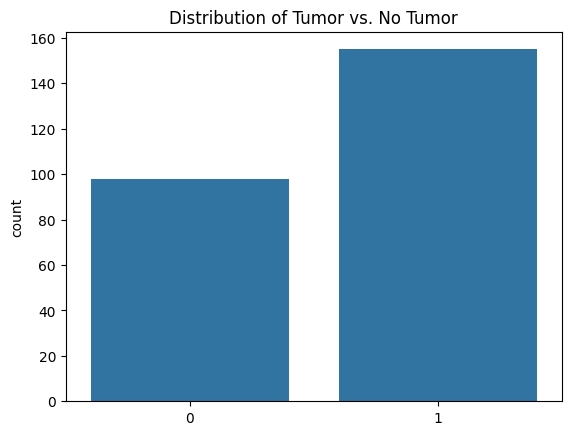

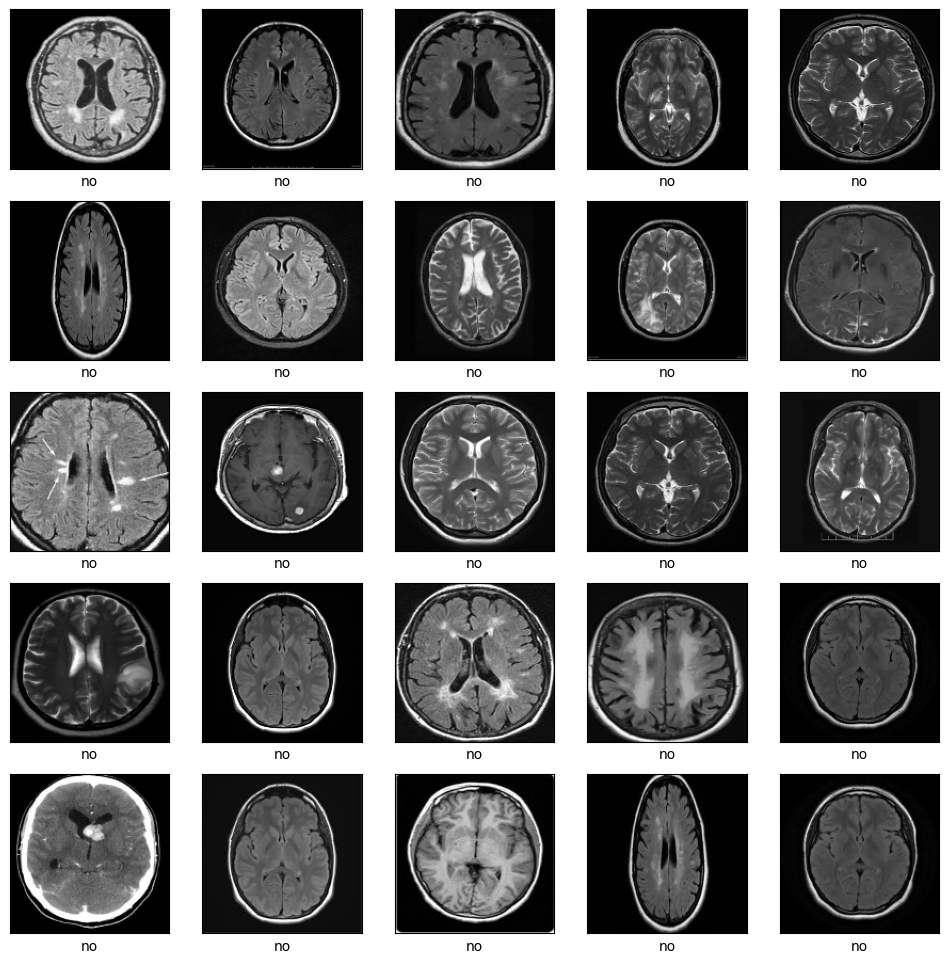

In [ ]:
# Define the path to the dataset and categories
data_dir = extract_path
categories = ['no', 'yes']

# Load and preprocess images
def load_images(data_dir, categories, image_size):
    data = []
    for category in categories:
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_img = cv2.resize(img_array, (image_size, image_size))
                data.append([resized_img, class_num])
            except Exception as e:
                pass
    return data

image_size = 150
data = load_images(data_dir, categories, image_size)

# Convert to numpy arrays
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, image_size, image_size, 1)
X = X / 255.0  # Normalize the data
y = np.array(y)

# Visualize the data distribution
sns.countplot(x=y)
plt.title('Distribution of Tumor vs. No Tumor')
plt.show()

# Visualize some images from the dataset
def visualize_images(X, y, categories):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i].reshape(image_size, image_size), cmap='gray')
        plt.xlabel(categories[y[i]])
    plt.show()

visualize_images(X, y, categories)

# Feature Engineering & Transformations

- Resize images to a consistent size (e.g., 150x150 pixels).
- Normalize pixel values.
- Apply data augmentation to increase dataset size and diversity.
- Further data preprocessing steps, such as noise removal and histogram equalization, if needed.

In [ ]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)
test_generator = val_datagen.flow(X_test, y_test, batch_size=32)


#  Hyperparameter Tuning with Random Search
Proposed Approaches (Model) with checks for overfitting/underfitting

# Proposed Approaches (Model) with Checks for Overfitting/Underfitting


- Develop a CNN architecture suitable for image classification.
- Implement techniques to address overfitting, such as dropout, data augmentation, and early stopping.

In [ ]:
!pip install bayesian-optimization

from bayes_opt import BayesianOptimization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

def build_and_train_model(conv_1_filter, conv_1_kernel, conv_2_filter, conv_2_kernel, conv_3_filter, conv_3_kernel, dense_units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Conv2D(filters=int(conv_1_filter), kernel_size=int(conv_1_kernel), activation='relu', input_shape=(image_size, image_size, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=int(conv_2_filter), kernel_size=int(conv_2_kernel), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=int(conv_3_filter), kernel_size=int(conv_3_kernel), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=int(dense_units), activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(2, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_generator, validation_data=val_generator, epochs=10, verbose=0)
    _, accuracy = model.evaluate(val_generator, verbose=0)
    return accuracy

# Define the parameter space
pbounds = {
    'conv_1_filter': (32, 128),
    'conv_1_kernel': (3, 5),
    'conv_2_filter': (32, 128),
    'conv_2_kernel': (3, 5),
    'conv_3_filter': (32, 128),
    'conv_3_kernel': (3, 5),
    'dense_units': (32, 128),
    'dropout_rate': (0.2, 0.5),
    'learning_rate': (0.0001, 0.01)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(f=build_and_train_model, pbounds=pbounds, verbose=2, random_state=42)
optimizer.maximize(init_points=10, n_iter=10)

# Get the best parameters
best_params = optimizer.max['params']
print(f"Best hyperparameters: {best_params}")


|   iter    |  target   | conv_1... | conv_1... | conv_2... | conv_2... | conv_3... | conv_3... | dense_... | dropou... | learni... |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.6053    | 67.96     | 4.901     | 102.3     | 4.197     | 46.98     | 3.312     | 37.58     | 0.4599    | 0.006051  |
| 2         | 0.6053    | 99.97     | 3.041     | 125.1     | 4.665     | 52.38     | 3.364     | 49.61     | 0.2913    | 0.005295  |
| 3         | 0.6053    | 73.47     | 3.582     | 90.74     | 3.279     | 60.05     | 3.733     | 75.78     | 0.4356    | 0.002077  |
| 4         | 0.6053    | 81.37     | 4.185     | 36.46     | 4.215     | 48.37     | 3.13      | 123.1     | 0.4897    | 0.008103  |
| 5         | 0.6053    | 61.24     | 3.195     | 97.69     | 3.88      | 43.72     | 3.99      | 35.3      | 0.4728    | 0.002662  |
| 6         | 0.6053    | 95.6      | 3.623     | 81.93     | 

# Train the Best Model
Requirement Fulfilled: Proposed Solution (Model Selection) with regularization, if needed

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Retrain the model with best hyperparameters and class weights
best_model = Sequential()
best_model.add(Conv2D(filters=int(best_params['conv_1_filter']), kernel_size=int(best_params['conv_1_kernel']), activation='relu', input_shape=(image_size, image_size, 1)))
best_model.add(MaxPooling2D(pool_size=(2, 2)))
best_model.add(Conv2D(filters=int(best_params['conv_2_filter']), kernel_size=int(best_params['conv_2_kernel']), activation='relu'))
best_model.add(MaxPooling2D(pool_size=(2, 2)))
best_model.add(Conv2D(filters=int(best_params['conv_3_filter']), kernel_size=int(best_params['conv_3_kernel']), activation='relu'))
best_model.add(MaxPooling2D(pool_size=(2, 2)))
best_model.add(Flatten())
best_model.add(Dense(units=int(best_params['dense_units']), activation='relu'))
best_model.add(Dropout(rate=best_params['dropout_rate']))
best_model.add(Dense(2, activation='softmax'))

optimizer_choice = Adam(learning_rate=best_params['learning_rate'])
best_model.compile(optimizer=optimizer_choice, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weights
)

# Evaluate the final model
test_loss, test_acc = best_model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.2f}')


Epoch 1/50
6/6 [==============================] - 35s 4s/step - loss: 0.7020 - accuracy: 0.5537 - val_loss: 0.6893 - val_accuracy: 0.6053
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 23s 4s/step - loss: 0.6977 - accuracy: 0.4350 - val_loss: 0.6967 - val_accuracy: 0.3947
Epoch 3/50
6/6 [==============================] - 24s 4s/step - loss: 0.6899 - accuracy: 0.4915 - val_loss: 0.7026 - val_accuracy: 0.3947
Epoch 4/50
6/6 [==============================] - 21s 4s/step - loss: 0.6979 - accuracy: 0.4350 - val_loss: 0.7008 - val_accuracy: 0.3947
Epoch 5/50
6/6 [==============================] - 22s 3s/step - loss: 0.6971 - accuracy: 0.4463 - val_loss: 0.6903 - val_accuracy: 0.6053
Epoch 6/50
6/6 [==============================] - 25s 4s/step - loss: 0.6925 - accuracy: 0.5706 - val_loss: 0.6919 - val_accuracy: 0.6053
Epoch 7/50
6/6 [==============================] - 23s 4s/step - loss: 0.6943 - accuracy: 0.5028 - val_loss: 0.6918 - val_accuracy: 0.6053
Epoch 8/50
6/6 [==============================] - 21s 4s/step - loss: 0.6919 - accuracy: 0.5989 - val_loss: 0.6920 - val_accuracy: 0.6053
Epoch 9/50
6/6 [=============================

# Explainable AI (Grad-CAM)
We will use Grad-CAM to visualize what the model is learning.

Last convolutional layer: conv2d_71


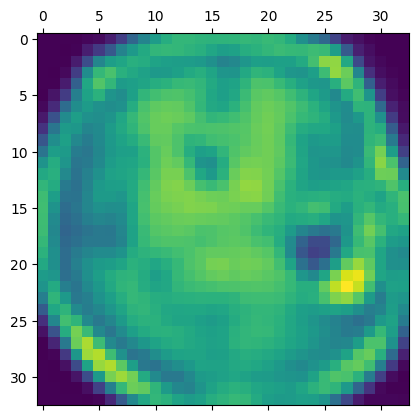

In [ ]:
# Function to find the last convolutional layer
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if 'conv' in layer.name:
            return layer.name
    raise ValueError("No convolutional layer found in the model")

last_conv_layer_name = find_last_conv_layer(best_model)
print(f"Last convolutional layer: {last_conv_layer_name}")

# Function to make Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Choose an image from the test set
img_array = X_test[0:1]

# Make Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, best_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


# Comprehensive Evaluation
Results (Accuracy) and Learnings from the methodology

2/2 [==============================] - 1s 178ms/step
ROC-AUC: 0.46
PR AUC: 0.73


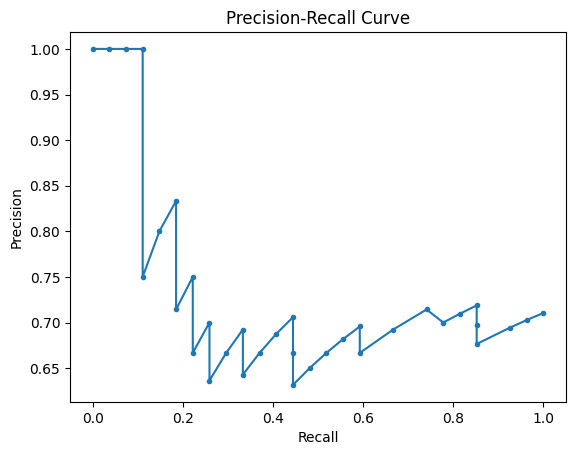

2/2 [==============================] - 1s 200ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.71      1.00      0.83        27

    accuracy                           0.71        38
   macro avg       0.36      0.50      0.42        38
weighted avg       0.50      0.71      0.59        38

[[ 0 11]
 [ 0 27]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, classification_report, confusion_matrix

# Predict probabilities
y_pred_proba = best_model.predict(test_generator)

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print(f'ROC-AUC: {roc_auc:.2f}')

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
pr_auc = auc(recall, precision)
print(f'PR AUC: {pr_auc:.2f}')

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Generate classification report and confusion matrix
predictions = best_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

print(classification_report(y_test, predicted_classes))
print(confusion_matrix(y_test, predicted_classes))